# Import Modules 

In [1]:
import seaborn as sns
sns.set()
sns.set_style(style='white') 
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

In [2]:
import os
import string
import pandas
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
from pyiron_dft_uncertainty import collect_data, \
    get_line, \
    shift_lst, \
    get_delta_project_recommendation, \
    get_materials_project_recommendation

# Loading precalculated data 

In [5]:
data_path = "pyiron/data/elements/"

In [6]:
file_lst = []
for f in os.listdir(data_path):
    if "2.csv" in f and "pre" not in f:
        file_lst.append(f)
file_lst = sorted(file_lst)

In [7]:
encut_space = np.linspace(200, 1200, 51)
encut_space

array([ 200.,  220.,  240.,  260.,  280.,  300.,  320.,  340.,  360.,
        380.,  400.,  420.,  440.,  460.,  480.,  500.,  520.,  540.,
        560.,  580.,  600.,  620.,  640.,  660.,  680.,  700.,  720.,
        740.,  760.,  780.,  800.,  820.,  840.,  860.,  880.,  900.,
        920.,  940.,  960.,  980., 1000., 1020., 1040., 1060., 1080.,
       1100., 1120., 1140., 1160., 1180., 1200.])

In [8]:
kpoint_space = np.linspace(3, 91, 45)  # This has to be updated 
kpoint_space

array([ 3.,  5.,  7.,  9., 11., 13., 15., 17., 19., 21., 23., 25., 27.,
       29., 31., 33., 35., 37., 39., 41., 43., 45., 47., 49., 51., 53.,
       55., 57., 59., 61., 63., 65., 67., 69., 71., 73., 75., 77., 79.,
       81., 83., 85., 87., 89., 91.])

In [9]:
element_lst = [f.split("_")[0] for f in file_lst]
element_lst

['Ag', 'Al', 'Au', 'Ca', 'Cu', 'Ir', 'Pb', 'Pd', 'Pt']

In [10]:
kpoint_mesh, encut_mesh = np.meshgrid(kpoint_space, encut_space)

In [11]:
kpoint_low_ind = 4
kpoint_low = kpoint_space[kpoint_low_ind]

In [12]:
file_pre_lst = [f.split("_")[0] + "_pre_vasp.csv" for f in file_lst]
file_pre_lst

['Ag_pre_vasp.csv',
 'Al_pre_vasp.csv',
 'Au_pre_vasp.csv',
 'Ca_pre_vasp.csv',
 'Cu_pre_vasp.csv',
 'Ir_pre_vasp.csv',
 'Pb_pre_vasp.csv',
 'Pd_pre_vasp.csv',
 'Pt_pre_vasp.csv']

# Initialize Method

In [13]:
degree = 11

In [14]:
uncertainty_parameter = {
    # Energy volume curve settings 
    'points': 21,
    'vol_range': 0.1
}

In [15]:
b0_stat_total_lst_lst, b0_approx_diff_mat_lst, b0_final_lst, b0_approx_diff_mat_ns_lst, b0_sys_total_lst_lst, encut_low_lst = [], [], [], [], [], []
for file_pre, file, el in zip(file_pre_lst, file_lst, element_lst):
    encut_low, b0_stat_total_lst, b0_sys_total_lst, b0_approx_diff_mat, b0_approx_diff_mat_ns = collect_data(
        file_pre=file_pre, 
        file=file, 
        el=el,
        encut_space=encut_space, 
        kpoint_space=kpoint_space,
        uncertainty_parameter=uncertainty_parameter,
        degree=degree,
        data_path=data_path
    )
    encut_low_lst.append(encut_low)
    b0_stat_total_lst_lst.append(b0_stat_total_lst)
    b0_sys_total_lst_lst.append(b0_sys_total_lst)
    b0_approx_diff_mat_lst.append(b0_approx_diff_mat)
    b0_approx_diff_mat_ns_lst.append(b0_approx_diff_mat_ns)
    b0_final_lst.append(np.array(b0_sys_total_lst)[-1, -1])

Ag 17.8383
Ag_sv_GW 360.0 11.0 8 4
Al 16.4568
Al_GW 260.0 11.0 3 4
Au 17.9783
Au_sv_GW 320.0 11.0 6 4
Ca 42.1356
Ca_sv_GW 300.0 11.0 5 4
Cu 11.9876
Cu_sv_GW 400.0 11.0 10 4
Ir 14.4888
Ir_sv_GW 320.0 11.0 6 4
Pb 32.0009
Pb_d 240.0 11.0 2 4
Pd 15.3085
Pd_sv_GW 360.0 11.0 8 4
Pt 15.6393
Pt_sv_GW 340.0 11.0 7 4


# Prediction

In [16]:
b0_level_abs_lst = [5, 1, 0.5, 0.1]
line_style_lst = ["-", "--", ":", "-."]

In [17]:
rows_count, columns_count = 3, 3

In [18]:
ind_lst = []
for i in range(rows_count):
    for j in range(columns_count):
        ind_lst.append([i, j])

In [19]:
line_lst, ind_limit_lst = [], []
for i, [file_pre, file, el, b0_stat_total_lst, b0_approx_diff_mat, b0_final, encut_low] in enumerate(zip(file_pre_lst, file_lst, element_lst, b0_stat_total_lst_lst, b0_approx_diff_mat_lst, b0_final_lst, encut_low_lst)):
    line_tmp_lst, ind_tmp_lst = [], []
    for b0_level, line_style in zip(b0_level_abs_lst, line_style_lst):
        line_data = get_line(limit=b0_level, encut_space=encut_space, mat=(b0_approx_diff_mat + np.array(b0_stat_total_lst)).T)
        ind_test = np.argmax([(len(encut_space) - 1 - encut_space.tolist().index(l)) * (len(kpoint_space)- 1 -k) for l, k in zip(line_data, range(len(kpoint_space)))])
        line_tmp_lst.append(line_data)
        ind_tmp_lst.append(ind_test)
    line_lst.append(line_tmp_lst)
    ind_limit_lst.append(ind_tmp_lst)

In [20]:
encut_el_lst, kpoint_el_lst = [], [] 
for line_tmp_lst, ind_tmp_lst in zip(line_lst, ind_limit_lst):
    encut_tmp_lst, kpoint_tmp_lst = [], [] 
    for line_data, ind_test in zip(line_tmp_lst, ind_tmp_lst):
        encut_tmp_lst.append(line_data[ind_test])
        kpoint_tmp_lst.append(kpoint_space[ind_test])
    encut_el_lst.append(encut_tmp_lst)
    kpoint_el_lst.append(kpoint_tmp_lst)


# Compare to Reference Data

In [21]:
delta = get_delta_project_recommendation()

In [22]:
mp = get_materials_project_recommendation(element_lst=element_lst, token="9wJlXz0bCHndCVkI")

In [23]:
pandas.DataFrame({
    "element": element_lst, 
    "encut_5GPa": np.array(encut_el_lst)[:,0],
    "kpoint_5GPa": np.array(kpoint_el_lst)[:,0],
    "encut_1GPa": np.array(encut_el_lst)[:,1],
    "kpoint_1GPa": np.array(kpoint_el_lst)[:,1],
    "encut_0.5GPa": np.array(encut_el_lst)[:,2],
    "kpoint_0.5GPa": np.array(kpoint_el_lst)[:,2],
    "encut_0.1GPa": np.array(encut_el_lst)[:,3],
    "kpoint_0.1GPa": np.array(kpoint_el_lst)[:,3],
})

,element,encut_5GPa,kpoint_5GPa,encut_1GPa,kpoint_1GPa,encut_0.5GPa,kpoint_0.5GPa,encut_0.1GPa,kpoint_0.1GPa
0,Ag,380.0,11.0,560.0,25.0,640.0,25.0,1160.0,65.0
1,Al,200.0,9.0,300.0,13.0,320.0,31.0,600.0,73.0
2,Au,320.0,15.0,500.0,23.0,560.0,25.0,1040.0,73.0
3,Ca,280.0,11.0,320.0,11.0,320.0,17.0,500.0,25.0
4,Cu,460.0,15.0,660.0,27.0,760.0,71.0,1180.0,75.0
5,Ir,380.0,13.0,540.0,19.0,640.0,19.0,760.0,31.0
6,Pb,240.0,7.0,260.0,15.0,260.0,21.0,800.0,39.0
7,Pd,400.0,11.0,580.0,19.0,620.0,27.0,1140.0,63.0
8,Pt,380.0,15.0,520.0,23.0,600.0,23.0,800.0,41.0


# Plot

In [24]:
element_ind_lst = [element_lst.index(els) for els in ["Ca", "Al", "Cu", "Pb", "Pd", "Ag", "Ir", "Pt", "Au"]]

In [25]:
levels = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100]

In [26]:
cmap = cm.get_cmap('Spectral').reversed()

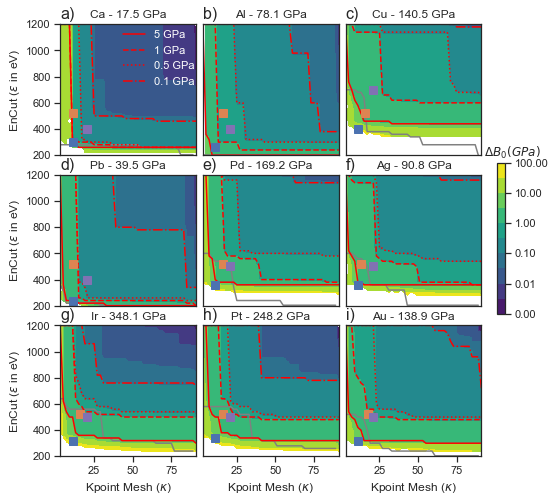

In [27]:
f, axs = plt.subplots(rows_count, columns_count, figsize=(6,6))
for n, ax in enumerate(axs.flatten()):
    ax.text(-0.0, 1.04, string.ascii_lowercase[n] + ")", transform=ax.transAxes, size=16)

for i, [file_pre, file, el, b0_stat_total_lst, b0_approx_diff_mat, b0_final, encut_low, line_tmp_lst, ind_tmp_lst] in enumerate(
    zip(np.array(file_pre_lst)[element_ind_lst], np.array(file_lst)[element_ind_lst], np.array(element_lst)[element_ind_lst], np.array(b0_stat_total_lst_lst)[element_ind_lst], np.array(b0_approx_diff_mat_lst)[element_ind_lst], np.array(b0_final_lst)[element_ind_lst], np.array(encut_low_lst)[element_ind_lst], np.array(line_lst)[element_ind_lst], np.array(ind_limit_lst)[element_ind_lst])
):
    axs[ind_lst[i][0], ind_lst[i][1]].set_title(el + " - " + str(np.round(b0_final, 1)) + " GPa")
    mappable = axs[ind_lst[i][0], ind_lst[i][1]].contourf(kpoint_mesh, encut_mesh, b0_approx_diff_mat + np.array(b0_stat_total_lst), vmin=np.min(levels), vmax=np.max(levels), levels=levels, norm=mcolors.LogNorm(), cmap="viridis")
    
    encut_opt_lst = [np.max(encut_space[sys<stat]) if sum(np.abs(sys)<stat) > 0 else np.min(encut_space)*1.02 for sys, stat in zip(b0_approx_diff_mat.T, np.array(b0_stat_total_lst).T)]
    axs[ind_lst[i][0], ind_lst[i][1]].plot(kpoint_space[:-1], shift_lst(np.array(encut_opt_lst[:-1])), "-", color="grey")
    
    for b0_level, line_style, line_data, ind_test in zip(b0_level_abs_lst, line_style_lst, line_tmp_lst, ind_tmp_lst):
        axs[ind_lst[i][0], ind_lst[i][1]].plot(kpoint_space, line_data, line_style, color="red", label=str(b0_level) + " GPa")    
    
    axs[ind_lst[i][0], ind_lst[i][1]].plot([kpoint_low], [encut_low], "s", markersize=8, color="C0")
    axs[ind_lst[i][0], ind_lst[i][1]].plot([(mp[mp.element == el].kpoint.values[0] ** 3 * 4) ** (1/3)], [mp[mp.element == el].encut.values[0]], "s", markersize=8, color="C1")
    axs[ind_lst[i][0], ind_lst[i][1]].plot([(delta[delta.element == el].kpoint.values[0] ** 3 * 4) ** (1/3)], [delta[delta.element == el].encut.values[0]], "s", markersize=8, color="C4")
    
    if ind_lst[i][0] == 2:
        axs[ind_lst[i][0], ind_lst[i][1]].set_xlabel("Kpoint Mesh ($\kappa$)")
    else: 
        axs[ind_lst[i][0], ind_lst[i][1]].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    if ind_lst[i][1] == 0:
        axs[ind_lst[i][0], ind_lst[i][1]].set_ylabel("EnCut ($\epsilon$ in eV)")
    else:
        axs[ind_lst[i][0], ind_lst[i][1]].tick_params(axis='y', which='both', right=False, left=False, labelleft=False)
    if i == 0:
        axs[ind_lst[i][0], ind_lst[i][1]].legend(labelcolor='white', frameon=False, bbox_to_anchor=(0.06, 0.45, 1., .102))
        
cbar_ax = f.add_axes([1.01, 0.33, 0.02, 0.35])
cbar = plt.colorbar(mappable, cax=cbar_ax)
cbar.ax.set_title("       $\Delta B_{0} (GPa)$")
plt.subplots_adjust(
    left=0.,
    bottom=0., 
    right=0.975, 
    top=1.0, 
    wspace=0.05, 
    hspace=0.15
)